In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
import seaborn as sns

# Load Online Retail dataset
The original dataset can be found here - http://archive.ics.uci.edu/ml/datasets/online+retail

It does have some outliers and missing data, and requires some cleaning. I have created a separate git repo for that, and saves the cleaned file as OnlineClean.xlsx - you can find the notebook, as well as original and cleaned datasets in the repo - https://github.com/karolisurbonas/cleaning-online-retail-dataset

I have also created a smaller version of the file with only `United Kingdom` filtered from the `Country` values, and randomly sampled 20% of the data for faster processing - the file is called `OnlineSampled.xlsx`.

In [2]:
# Pre-processed file
#online = pd.read_excel('OnlineClean.xlsx')

# Further cleaned file: UK-only, randomly sampled 20% of the data
#online = pd.read_excel('OnlineSampled.xlsx')
# online = pd.read_csv('OnlineSampled12M.csv', index_col=[0], parse_dates=['InvoiceDate'])
online = pd.read_csv('OnlineSampled.csv', index_col=[0], parse_dates=['InvoiceDate'])

## RFM and Clustering Segmentation goals

We will build summary datasets on a `CustomerID` level for the RFM and Clustering analyses. We will calculate these values:

1. Tier 1 metrics for RFM segmentation:
 - **Recency** - Days since last transaction
 - **Frequency** - Total number of transactions
 - **MonetaryValue** - Total sum of money spent with the company
 - **Tenure** - days since first transaction


2. Tier 2 metrics for more advanced segmentation (clustering):
 - **Frequency Monthly** - Average number of transactions monthly
 - **QuantityTotal** - Total number of items bought with the company (sum of `Quantity`)
 - **QuantityMonthly** - Average number of items bought monthly
 - **PriceAverage** - Average Unit Price of each purchase
 - **MonetaryValueMonthly** - Average sum of money spent with the company monthly
 - **MonthsActive** - Number of months when customer shopped at the store
 - **DaysActive** - Count of active days
 - **AverageDaysActiveMonthly** - Average days active in a month since first transaction
 - **DaysActiveShare** - Share of active days of total tenure in days

Then we will rund the RFM segmentation on the tier 1 metrics, and discuss potential uses of it. 

In the last section we will use both tier 1 and tier 2 metrics to run cluster analysis to uncover behavioral segments, and see if adding more features (tier 2 metrics) can get us to a more interpretable segmentation solution.

In [3]:
online['CustomerID'] = online['CustomerID'].astype(int)
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom
263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom
495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom
204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom


# 1. Data preparation for RFM segmentation

### Convert InvoiceDate from datetime object to a date

Let's remove the time from the `InvoiceDate` and leave it as a date only.

In [4]:
online['InvoiceDate'] = online['InvoiceDate'].dt.date

### Further data cleaning

Typically for RFM analysis we need 1 year's worth of data, so let's restrict our dataset to have 12 months of data only.

In [5]:
print('Min:{}; Max:{}'.format(min(online.InvoiceDate),
                              max(online.InvoiceDate)))

Min:2010-12-01; Max:2011-12-09


In [6]:
online = online[online['InvoiceDate']>dt.date(2010,12,9)]

Now, let's create a monthly date so we can aggregate monthly metrics later

In [7]:
# online['InvoiceMonth'] = online['InvoiceDate'].apply(lambda x: dt.date(x.year, x.month, 1))

In [8]:
online.to_csv('OnlineSampled12M.csv')

In [9]:
online[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25,2.10,14286,United Kingdom
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20,1.45,16360,United Kingdom
263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14,3.75,13933,United Kingdom
495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23,2.10,17290,United Kingdom
204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25,5.95,17663,United Kingdom


### Create snapshot date

In the real world, we would typically be able to access such data daily with the most recent transactions present. Since this dataset is historical and we can't update it with the most recent numbers, we have to assume that the time when it was pulled was +1 day after the last transaction was recorded. 

First, let's check the smallest and largest `InvoiceDate` values, and then we can create a new variable `snapshot_date` which we will use for the RFM calculations.

In [10]:
print('Min date = {}, Max date = {}'.format(min(online.InvoiceDate), max(online.InvoiceDate)))

Min date = 2010-12-10, Max date = 2011-12-09


In [11]:
snapshot_date = max(online.InvoiceDate) + dt.timedelta(days=1)

### Calculate purchase value

Let's calculate the basket value by multiplying `Quantity` and `UnitPrice` and storing this into `TotalSum` variable.

In [12]:
online['TotalSum'] = online['Quantity'] * online['UnitPrice']
online[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25,2.10,14286,United Kingdom,12.60
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20,1.45,16360,United Kingdom,1.45
263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14,3.75,13933,United Kingdom,22.50
495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23,2.10,17290,United Kingdom,2.10
204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25,5.95,17663,United Kingdom,17.85


# 2. Create segmentation datamart

In this section we will create a new DataFrame called `datamart` which will store values at a `CustomerID` level for further RFM and clustering analyses.

## 2.1. Add Tier 1 metrics

First, we will calculate tier 1 metrics. Let's first add three main metrics: Recency (R), Frequency (F), and Monetary Value (M)

In [13]:
datamart = online.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})

Next, we need to rename the columns so they are easier to interpret.

In [14]:
datamart.rename(columns = {'InvoiceDate': 'Recency',
                           'InvoiceNo': 'Frequency',
                           'TotalSum': 'MonetaryValue'}, inplace=True)
datamart.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,3,25,948.70
12748,1,888,7046.16
12749,4,37,813.45
12820,4,17,268.02
12822,71,9,146.15


Finally, let's add `Tenure` variable.

In [15]:
datamart['Tenure'] = online.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.min()).days}).sort_index(ascending=True)

In [16]:
datamart.head()

,Recency,Frequency,MonetaryValue,Tenure
CustomerID,,,,
12747,3,25,948.70,362
12748,1,888,7046.16,365
12749,4,37,813.45,214
12820,4,17,268.02,327
12822,71,9,146.15,88


In [17]:
datamart.to_csv('rfm_datamart.csv')

In [18]:
datamart2 = pd.read_csv('rfm_datamart.csv', index_col=[0])
datamart2.head()

,Recency,Frequency,MonetaryValue,Tenure
CustomerID,,,,
12747,3,25,948.70,362
12748,1,888,7046.16,365
12749,4,37,813.45,214
12820,4,17,268.02,327
12822,71,9,146.15,88


In [19]:
print(max(datamart2['Frequency']), np.median(datamart2['Frequency']), np.mean(datamart2['Frequency']))

1497 9.0 18.71424650013725


## 2.2. Add Tier 2 metrics

In this section we will calculate each metric with a separate code line for easier interpretation.

In [20]:
# datamart['FrequencyMonthly'] = (online.groupby(['CustomerID', 'InvoiceMonth'])['InvoiceNo'].agg('count').
#                                 groupby(['CustomerID']).mean().sort_index(ascending=True))

# datamart['QuantityTotal'] = (online.groupby(['CustomerID'])['Quantity'].agg('sum').sort_index(ascending=True))

# datamart['PriceAverage'] = (online.groupby(['CustomerID'])['UnitPrice'].mean().sort_index(ascending=True))

# datamart['MonetaryValueMonthly'] = (online.groupby(['CustomerID', 'InvoiceMonth'])['TotalSum'].agg('sum').
#                                 groupby(['CustomerID']).mean().sort_index(ascending=True))

# datamart['MonthsActive'] = (online.groupby(['CustomerID'])['InvoiceMonth'].nunique().sort_index(ascending=True))

# datamart['DaysActive'] = (online.groupby(['CustomerID'])['InvoiceDate'].nunique().sort_index(ascending=True))

# datamart['AverageDaysActiveMonthly'] = datamart['DaysActive'] / datamart['MonthsActive']

# datamart['DaysActiveShare'] = datamart['DaysActive'] / datamart['Tenure']

In [21]:
# datamart[30:40]

### Correlation heatmap

Let's check it out if any of our features are correlated. We are going to use `.corr()` method on the `datamart` we have just created, and then plot it as a heatmap using `seaborn` library.

Good link for seaborn color palettes - https://chrisalbon.com/python/data_visualization/seaborn_color_palettes/

In [22]:
correlation_m = datamart.corr().round(2)
correlation_m

,Recency,Frequency,MonetaryValue,Tenure
Recency,1.00,-0.22,-0.14,0.29
Frequency,-0.22,1.00,0.36,0.22
MonetaryValue,-0.14,0.36,1.00,0.17
Tenure,0.29,0.22,0.17,1.00


**Before plotting heatmap**, we might want to remove the information in the correlation matrix as half of it is redundant i.e. lower triangle and upper triangle of the matrix are the same, except for the diagonal which is the correlation for each variable of itself, and always accounts to 100%.

We will do that by using `numpy` function `tril_indices` which calculates **[l]**ower **[tri]**angle indices. Then we will create a `mask` variable that we will pass to the `heatmap` function call.

You can read more about the `tril_indices` function [here](https://docs.scipy.org/doc/numpy/reference/generated/numpy.triu_indices.html). There are also functions like `triu_indices` for the **u**pper **tri**angle indices, or functions `tril` and `triu` that return zeros for either lower or upper part of the triangle matrix.

In [23]:
il = np.tril_indices(correlation_m.shape[0], -1)
mask = np.zeros_like(correlation_m)
mask[il] = True

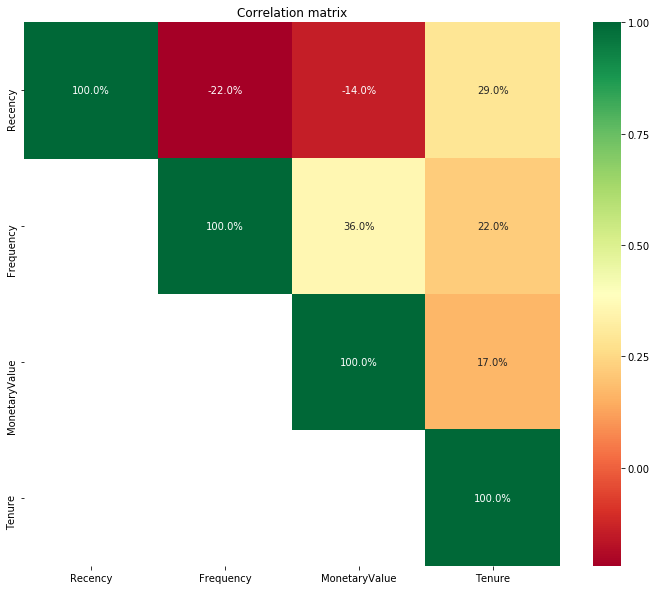

In [24]:
plt.figure(figsize=(12, 10))
plt.title('Correlation matrix')
sns.heatmap(correlation_m, annot=correlation_m, cmap='RdYlGn', fmt='.1%', mask=mask)
plt.show()

# 3. Create RFM table and analyze RFM segments

We will first create three columns `R`, `F`, and `M` that will be the RFM scores. There are multiple ways to assign these values:
 1. Based on quartile (or other percentile) values
 2. Pareto (80/20)
 3. Custom - based on business or market knowledge

In this section, we will implement quartile (**No. 1**) approach.

In [25]:
r_labels = range(4, 0, -1)
r_quartiles = pd.qcut(datamart['Recency'], 4, labels = r_labels)
datamart = datamart.assign(R = r_quartiles.values)

In [26]:
datamart[:5]

,Recency,Frequency,MonetaryValue,Tenure,R
CustomerID,,,,,
12747,3,25,948.70,362,4
12748,1,888,7046.16,365,4
12749,4,37,813.45,214,4
12820,4,17,268.02,327,4
12822,71,9,146.15,88,2


Now let's assign `F`, `M`, and `T` (for **T**enure) values based on quartiles.

For `Frequency`, `MonetaryValue` and `Tenure` we will have to reverse the labels because in this case the larger the value, the better, while with `Recency` we want these values

In [27]:
f_labels = range(1,5)
f_quartiles = pd.qcut(datamart['Frequency'], 4, labels = f_labels)
datamart = datamart.assign(F = f_quartiles.values)

In [28]:
datamart[:5]

,Recency,Frequency,MonetaryValue,Tenure,R,F
CustomerID,,,,,,
12747,3,25,948.70,362,4,4
12748,1,888,7046.16,365,4,4
12749,4,37,813.45,214,4,4
12820,4,17,268.02,327,4,3
12822,71,9,146.15,88,2,2


In [29]:
m_labels = range(1,5)
m_quartiles = pd.qcut(datamart['MonetaryValue'], 4, labels = m_labels)
datamart = datamart.assign(M = m_quartiles.values)

# Tquartiles = pd.qcut(datamart['Tenure'], 4, labels = range(1,5))
# datamart = datamart.assign(T = Tquartiles.values)

In [30]:
datamart[:5]

,Recency,Frequency,MonetaryValue,Tenure,R,F,M
CustomerID,,,,,,,
12747,3,25,948.70,362,4,4,4
12748,1,888,7046.16,365,4,4,4
12749,4,37,813.45,214,4,4,4
12820,4,17,268.02,327,4,3,3
12822,71,9,146.15,88,2,2,3


In [31]:
# datamart['RFM_Segment'] = datamart[['R','F','M']].apply(lambda x: ''.join(x.map(str)), axis=1)

In [32]:
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
                                                        
datamart['RFM_Segment'] = datamart.apply(join_rfm, axis=1)

In [33]:
datamart['RFM_Score'] = datamart[['R','F','M']].sum(axis=1)

In [34]:
datamart[datamart['RFM_Segment']=='111'][:5]
#.sort_values('MonetaryValue', ascending=False)

,Recency,Frequency,MonetaryValue,Tenure,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,,
12837,174,2,10.55,174,1,1,1,111,3.0
12852,295,2,32.55,295,1,1,1,111,3.0
12902,265,4,42.03,265,1,1,1,111,3.0
12915,149,2,35.90,149,1,1,1,111,3.0
12922,162,4,57.24,162,1,1,1,111,3.0


In [35]:
datamart.sort_values('RFM_Segment', ascending=False)[:10]

,Recency,Frequency,MonetaryValue,Tenure,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,,
12747,3,25,948.70,362,4,4,4,444,12.0
16474,8,65,336.62,146,4,4,4,444,12.0
16592,5,44,826.25,288,4,4,4,444,12.0
16570,16,23,807.65,312,4,4,4,444,12.0
16558,1,84,1738.59,358,4,4,4,444,12.0
16549,11,191,767.74,335,4,4,4,444,12.0
16523,2,55,1698.64,316,4,4,4,444,12.0
13742,17,59,569.51,321,4,4,4,444,12.0
16458,3,39,699.57,361,4,4,4,444,12.0


In [36]:
datamart.sort_values('MonetaryValue', ascending=False)[:10]

,Recency,Frequency,MonetaryValue,Tenure,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,,
18102,2,76,48060.35,208,4,4,4,444,12.0
17450,11,64,36160.84,333,4,4,4,444,12.0
17511,3,175,16805.44,360,4,4,4,444,12.0
16029,45,28,14748.47,359,3,4,4,344,11.0
16684,5,57,14708.96,359,4,4,4,444,12.0
15749,236,3,13698.50,333,1,1,4,114,6.0
14096,5,1055,13300.10,102,4,4,4,444,12.0
13694,4,115,12768.03,359,4,4,4,444,12.0
14088,11,141,11812.27,323,4,4,4,444,12.0


In [37]:
datamart.to_csv('datamart_full.csv')

In [38]:
datamart_test = pd.read_csv('datamart_full.csv', index_col=[0])
datamart[:5]

,Recency,Frequency,MonetaryValue,Tenure,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,,
12747,3,25,948.70,362,4,4,4,444,12.0
12748,1,888,7046.16,365,4,4,4,444,12.0
12749,4,37,813.45,214,4,4,4,444,12.0
12820,4,17,268.02,327,4,3,3,433,10.0
12822,71,9,146.15,88,2,2,3,223,7.0


In [39]:
datamart.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3.0         246.9       2.1          28.4   345
4.0         162.2       3.1          47.8   337
5.0         138.9       4.3          78.2   393
6.0         101.0       6.3         146.3   444
7.0          78.0       8.5         160.2   382
8.0          62.6      12.8         196.3   376
9.0          46.8      16.7         330.3   345
10.0         31.9      24.0         443.1   355
11.0         21.8      38.9         705.3   294
12.0          8.0      75.6        1653.9   372

In [40]:
datamart.groupby('RFM_Segment').size().sort_values(ascending=False)[:10]

RFM_Segment
444    372
111    345
211    169
344    156
233    129
222    128
333    120
122    117
311    114
433    113
dtype: int64

In [41]:
datamart.groupby('RFM_Segment').size().sort_values(ascending=True)[:10]

RFM_Segment
141     1
341     1
124     3
142     5
414     5
314     6
413     9
134    10
224    12
324    13
dtype: int64

In [42]:
def segment_me(df):
    if df['RFM_Score'] >= 9:
        return '1. Gold'
    elif (df['RFM_Score'] >= 5) and (df['RFM_Score'] < 9):
        return '2. Silver'
    else:
        return '3. Bronze'

datamart['General_Segment'] = datamart.apply(segment_me, axis=1)
datamart[:5]

,Recency,Frequency,MonetaryValue,Tenure,R,F,M,RFM_Segment,RFM_Score,General_Segment
CustomerID,,,,,,,,,,
12747,3,25,948.70,362,4,4,4,444,12.0,1. Gold
12748,1,888,7046.16,365,4,4,4,444,12.0,1. Gold
12749,4,37,813.45,214,4,4,4,444,12.0,1. Gold
12820,4,17,268.02,327,4,3,3,433,10.0,1. Gold
12822,71,9,146.15,88,2,2,3,223,7.0,2. Silver


In [43]:
datamart.groupby('General_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
1. Gold            27.0      39.4         800.8  1366
2. Silver          95.8       7.9         144.6  1595
3. Bronze         205.0       2.6          38.0   682

# 4. Customer segmentation by clustering

In this section we will use `Recency`, `Frequency`, and `MonetaryValue` variables to segment the customers into homogenous groups using K-means clustering algorithm. 

Later, we will explore how adding additional variables like `Tenure` and others impacts the segmentation solution.

Then, we will run a clustering exercise on the full dataset, and see if the additional features give us more interpretable segments.

Finally, we will review other techniques like [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), [Gaussian Mixture Models](http://scikit-learn.org/stable/modules/mixture.html) and [NMF](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) to show how they can be used in extracting insights into the data and build segmentation projects.

## 4.1. Clustering with k-means on tier 1 metrics

In [44]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [45]:
# Filter out 3 key metrics for the first iteration
rfm_index = ['Recency', 'Frequency', 'MonetaryValue']
datamart_rfm = datamart[rfm_index]

### Pre-process data for Kmeans

KMeans algorithm works best with normally-distributed and standardized data, so we will first run a log transformation to reduce the skew and compress the heavy tails. Then, we will scale and center the data, so the mean and variance are the standardized.

More information about data preparation for KMeans - https://stats.stackexchange.com/questions/325676/should-k-means-only-be-applied-if-the-variables-are-normally-distributed

In [46]:
datamart_rfm.describe()

,Recency,Frequency,MonetaryValue
count,3643.00000,3643.000000,3643.000000
mean,90.43563,18.714247,370.694387
std,94.44651,43.754468,1347.443451
min,1.00000,1.000000,0.650000
25%,19.00000,4.000000,58.705000
50%,51.00000,9.000000,136.370000
75%,139.00000,21.000000,334.350000
max,365.00000,1497.000000,48060.350000


In [47]:
datamart_rfm.to_csv('datamart_rfm.csv')

In [48]:
datamart_rfm = pd.read_csv('datamart_rfm.csv', index_col=[0])

In [49]:
# Transform inputs to a log scale
datamart_log = np.log(datamart_rfm)

In [50]:
datamart_log.to_csv('datamart_log.csv')

In [51]:
datamart_log = pd.read_csv('datamart_log.csv', index_col=[0])

In [52]:
# Standardize the data by centering and scaling
scaler = StandardScaler()
scaler.fit(datamart_log)
data_3rfm = scaler.transform(datamart_log)

### Evaluate the number of clusters using Elbow Method

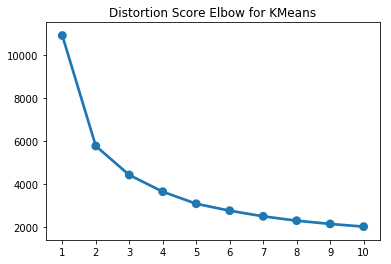

In [53]:
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=99).fit(data_3rfm)
    cluster_labels = kmeans.labels_
    sse[k] = kmeans.inertia_
    # Inertia = Sum of squared distances of samples to their closest cluster center.

plt.title('Distortion Score Elbow for KMeans')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

### Evaluate the number of clusters using Silhouette Score

Documentation here - http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

Ultimately, we will make the call about the right number of clusters based on the interpretability of the segmentation solution. This method, along with the elbow method described above, gives us guidance of what is the range of the number of clusters we should explore.

As you can see in the thread in stackoverflow [here](https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion), while the Silhouette score is highest for the 2-cluster solution, while the underlying dataset has three very distint classes, so we should always take these scores as directional insights, that will guide us towards the best\* solution. 

*
**Best** solution will be the one that makes most sense and enables the business owners and managers to act upon the insights provided by the segmentation.*

In [54]:
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=99).fit(data_3rfm)
    cluster_labels = kmeans.labels_
    sil_score = silhouette_score(data_3rfm, cluster_labels, metric='euclidean')
    print("K: {}, Silhouette Score: {}".format(k, sil_score))

K: 2, Silhouette Score: 0.38951947314000934
K: 3, Silhouette Score: 0.30064801591685403
K: 4, Silhouette Score: 0.29699380564901073
K: 5, Silhouette Score: 0.28334525552636175
K: 6, Silhouette Score: 0.2771596978112224
K: 7, Silhouette Score: 0.26274237869542444
K: 8, Silhouette Score: 0.2613922624770596
K: 9, Silhouette Score: 0.26636330142791675
K: 10, Silhouette Score: 0.26643170630323637


### Fancy visualizations for Elbow Method and Silhouette Score

[**Yellowbrik**](http://www.scikit-yb.org/en/latest/index.html) is an extension to Scikit Learn API with a series of visualization tools. You will have to install it (`pip install yellowbrik` did the job to me) before you can use it. You can import them with the following commands.

`from yellowbrick.cluster import KElbowVisualizer`

`from yellowbrick.cluster import SilhouetteVisualizer`

I prefer using the simple calculations like above from the main `sklearn` API, as the ones from `Yellowbrik` do not always match the previous results.

### Running Kmeans clustering and comparing results for different K

Now we will review the metrics - `Recency`, `Frequency` and `Monetary Value` - for each cluster based on different segmentation solutions i.e. varying K values. 

We will be looking to find interpretable segments that make sense from business perspective. This is a critical moment where feedback from the business teams is very important, as we want to merge industry knowledge with the story that the segmentation speaks. 

### 2-cluster solution



In [55]:
kmeans = KMeans(n_clusters=2, random_state=99).fit(data_3rfm)
cluster_labels = kmeans.labels_
datamart.assign(cluster = cluster_labels).groupby(['cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count'],
}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
cluster                                      
0          32.0      35.0         719.0  1620
1         137.0       5.0          92.0  2023

### 3-cluster solution

In [56]:
kmeans = KMeans(n_clusters=3, random_state=99).fit(data_3rfm)
cluster_labels = kmeans.labels_
datamart.assign(cluster = cluster_labels).groupby(['cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count'],
}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
cluster                                      
0         167.0       3.0          53.0  1155
1          77.0      12.0         214.0  1577
2          16.0      50.0        1045.0   911

In [57]:
np.savetxt('cluster_labels_k3_rfm.csv', cluster_labels.astype(int), fmt='%i', delimiter=',')

In [58]:
cluster_labels_k3_rfm = np.loadtxt('cluster_labels_k3_rfm.csv', delimiter=',')
cluster_labels_k3_rfm = cluster_labels_k3_rfm.astype(int)

In [59]:
cluster_labels_k3_rfm[:20]

array([2, 2, 2, 2, 1, 0, 1, 2, 0, 2, 0, 1, 1, 0, 1, 2, 0, 1, 2, 1])

In [60]:
cluster_labels[:20]

array([2, 2, 2, 2, 1, 0, 1, 2, 0, 2, 0, 1, 1, 0, 1, 2, 0, 1, 2, 1])

In [61]:
len(cluster_labels)

3643

### 4-cluster solution

In [62]:
kmeans = KMeans(n_clusters=4, random_state=99).fit(data_3rfm)
cluster_labels = kmeans.labels_
datamart.assign(cluster = cluster_labels).groupby(['cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count'],
}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
cluster                                      
0          20.0      10.0         145.0   768
1         129.0      12.0         232.0  1091
2         165.0       3.0          44.0   949
3          19.0      54.0        1130.0   835

### 5-cluster solution

In [63]:
kmeans = KMeans(n_clusters=5, random_state=99).fit(data_3rfm)
cluster_labels = kmeans.labels_
datamart.assign(cluster = cluster_labels).groupby(['cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count'],
}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
cluster                                      
0          19.0       9.0         117.0   658
1           9.0      65.0        1444.0   532
2          57.0      24.0         431.0   826
3         163.0       7.0         133.0   977
4         163.0       2.0          30.0   650

### 6-cluster solution

In [64]:
kmeans = KMeans(n_clusters=6, random_state=99).fit(data_3rfm)
cluster_labels = kmeans.labels_
datamart.assign(cluster = cluster_labels).groupby(['cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count'],
}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
cluster                                      
0         184.0       2.0          29.0   545
1          62.0      22.0         409.0   806
2          11.0      78.0        1759.0   415
3         179.0       7.0         135.0   846
4           9.0      17.0         268.0   434
5          32.0       6.0          74.0   597

### 7-cluster solution

In [65]:
kmeans = KMeans(n_clusters=7, random_state=99).fit(data_3rfm)
cluster_labels = kmeans.labels_
datamart.assign(cluster = cluster_labels).groupby(['cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count'],
}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
cluster                                      
0         102.0      13.0         200.0   781
1           6.0      82.0        1860.0   328
2          31.0       5.0          66.0   510
3         208.0       4.0         102.0   641
4          43.0      35.0         695.0   525
5         180.0       2.0          21.0   387
6          12.0      15.0         240.0   471

# NMF
http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

https://stackoverflow.com/questions/29648955/sklearn-matrix-factorization-example

# DATACAMP CAPSTONE - RFM

In [66]:
data = datamart.reset_index()

In [67]:
# Tquartiles = pd.qcut(data['Tenure'], 4, labels = list(reversed(range(1,5))))
# data = data.assign(T = Tquartiles.values)
# top_recency = data[data['M']==1]
# monetary = top_recency.groupby(['RFM_Score', 'T'])['CustomerID'].nunique().reset_index()
# mypivot = monetary.pivot(index='RFM_Score', columns='T', values='CustomerID')
# print(mypivot)

# Capstone 2.1. - preparing data for clustering

In [68]:
datamart[:5]

,Recency,Frequency,MonetaryValue,Tenure,R,F,M,RFM_Segment,RFM_Score,General_Segment
CustomerID,,,,,,,,,,
12747,3,25,948.70,362,4,4,4,444,12.0,1. Gold
12748,1,888,7046.16,365,4,4,4,444,12.0,1. Gold
12749,4,37,813.45,214,4,4,4,444,12.0,1. Gold
12820,4,17,268.02,327,4,3,3,433,10.0,1. Gold
12822,71,9,146.15,88,2,2,3,223,7.0,2. Silver


In [69]:
# label_index = ['FrequencyMonthly', 'PriceAverage', 'Tenure']
# datamart_kmeans = datamart[label_index]

In [70]:
# writer = pd.ExcelWriter('datamart_kmeans.xlsx')
# datamart_kmeans[:5].to_excel(writer, 'Sheet1')
# writer.save()

In [71]:
# datamart_kmeans[:5]

In [72]:
# Transform inputs to a log scale
# data_log = np.log(datamart_kmeans)

In [73]:
# Standardize the data by centering and scaling
# scaler = StandardScaler()
# scaler.fit(data_log)
# data_log_and_scaled = scaler.transform(data_log)
# data_log_and_scaled[0:10]

# Capstone 2.2. - clustering 3 clusters

In [74]:
# kmeans = KMeans(n_clusters=4, random_state=99).fit(data_log_and_scaled)
# cluster_labels = kmeans.labels_
# datamart = datamart.assign(cluster = cluster_labels)
# datamart.groupby(['cluster']).agg({
#     'FrequencyMonthly': 'mean',
#     'PriceAverage': 'mean',
#     'Tenure': 'mean',
#     'MonetaryValue': ['mean', 'count']
# }).round(1)

In [75]:
np.random.seed(1)
customer_id = range(8)
spend = np.random.randint(100,400, 8)
data = pd.DataFrame(data={'CustomerID': customer_id,
                          'Spend': spend})
data

,CustomerID,Spend
0,0,137
1,1,335
2,2,172
3,3,355
4,4,303
5,5,233
6,6,244
7,7,229


In [76]:
spend_quartile = pd.qcut(data['Spend'], 
                          q=4, labels=range(1,5))
data['Spend_Quartile'] = spend_quartile
data.sort_values('Spend')

,CustomerID,Spend,Spend_Quartile
0,0,137,1
2,2,172,1
7,7,229,2
5,5,233,2
6,6,244,3
4,4,303,3
1,1,335,4
3,3,355,4


In [77]:
np.random.seed(1)
customer_id = range(8)
recency_days = np.random.randint(0, 400, 8)
data = pd.DataFrame(data={'CustomerID': customer_id,
                          'Recency_Days': recency_days})
r_labels = list(range(4,0,-1))
recency_quartiles = pd.qcut(data['Recency_Days'], q=4, labels=r_labels)
data['Recency_Quartile'] = recency_quartiles 
data.sort_values('Recency_Days') 

,CustomerID,Recency_Days,Recency_Quartile
0,0,37,4
3,3,72,4
7,7,133,3
6,6,203,3
1,1,235,2
4,4,255,2
5,5,393,1
2,2,396,1


In [78]:
np.random.seed(1)
customer_id = range(8)
recency_days = np.random.randint(0, 400, 8)
data = pd.DataFrame(data={'CustomerID': customer_id,
                          'Recency_Days': recency_days})
r_labels = ['Active', 'Lapsed', 'Inactive', 'Churned']
recency_quartiles = pd.qcut(data['Recency_Days'], q=4, labels=r_labels)
data['Recency_Quartile'] = recency_quartiles 
data.sort_values('Recency_Days') 

,CustomerID,Recency_Days,Recency_Quartile
0,0,37,Active
3,3,72,Active
7,7,133,Lapsed
6,6,203,Lapsed
1,1,235,Inactive
4,4,255,Inactive
5,5,393,Churned
2,2,396,Churned


In [79]:
datamart = pd.read_csv('rfm_datamart.csv', index_col=[0])
datamart.head()
# Create labels for `Recency` with a decreasing range of 3 through 1 
r_labels = range(3, 0, -1)

# Assign these labels to three equal percentile groups based on `Recency` 
r_groups = pd.qcut(datamart['Recency'], q=3, labels = r_labels)

# Create labels for `Frquency` with an increasing range of 1 through 3
f_labels = range(1,4)

# Assign these labels to three equal percentile groups based on `Frequency` 
f_groups = pd.qcut(datamart['Frequency'], q=3, labels = f_labels)

# Create new columns `R` and `F` based on Recency and Frequency percentile groups respectively
datamart = datamart.assign(R = r_groups.values, F = f_groups.values)
datamart.to_csv('datamart_3groups.csv')

In [80]:
datamart = pd.read_csv('datamart_3groups.csv', index_col=[0])
datamart.head()


,Recency,Frequency,MonetaryValue,Tenure,R,F
CustomerID,,,,,,
12747,3,25,948.70,362,3,3
12748,1,888,7046.16,365,3,3
12749,4,37,813.45,214,3,3
12820,4,17,268.02,327,3,3
12822,71,9,146.15,88,2,2


# EX

In [81]:
datamart = pd.read_csv('datamart_full.csv', index_col=[0])
datamart[:5]

,Recency,Frequency,MonetaryValue,Tenure,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,,
12747,3,25,948.70,362,4,4,4,444,12.0
12748,1,888,7046.16,365,4,4,4,444,12.0
12749,4,37,813.45,214,4,4,4,444,12.0
12820,4,17,268.02,327,4,3,3,433,10.0
12822,71,9,146.15,88,2,2,3,223,7.0


In [82]:
# Define `rfm_level` function
def rfm_level(df):
    if df['RFM_Score'] >= 10:
        return 'Top'
    elif (df['RFM_Score'] >= 6) and (df['RFM_Score'] < 10):
        return 'Middle'
    else:
        return 'Low'

# Apply the function to the `datamart` and create a new variable `RFM_Level`
datamart['RFM_Level'] = datamart.apply(rfm_level, axis=1)

# Print top 5 rows to the console
print(datamart[:5])
datamart.to_csv('datamart_rfm_level_segment.csv')

            Recency  Frequency  MonetaryValue  Tenure  R  F  M  RFM_Segment  \
CustomerID                                                                    
12747             3         25         948.70     362  4  4  4          444   
12748             1        888        7046.16     365  4  4  4          444   
12749             4         37         813.45     214  4  4  4          444   
12820             4         17         268.02     327  4  3  3          433   
12822            71          9         146.15      88  2  2  3          223   

            RFM_Score RFM_Level  
CustomerID                       
12747            12.0       Top  
12748            12.0       Top  
12749            12.0       Top  
12820            10.0       Top  
12822             7.0    Middle  


In [83]:
datamart.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Level                                      
Low         180.8       3.2          52.7  1075
Middle       73.9      10.7         202.9  1547
Top          20.3      47.1         959.7  1021

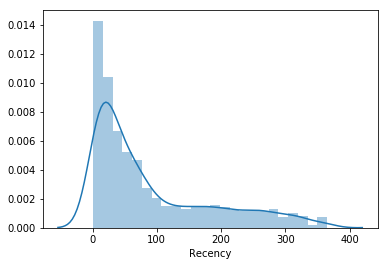

In [84]:
sns.distplot(datamart['Recency'])
plt.show()

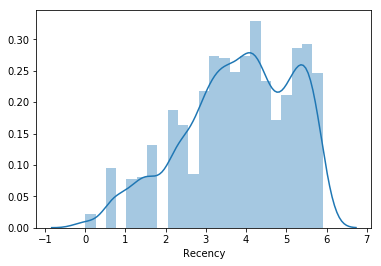

In [85]:
recency_log = np.log(datamart['Recency'])
sns.distplot(recency_log)
plt.show()

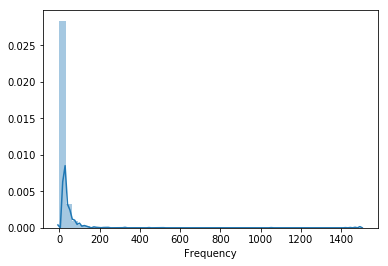

In [86]:
sns.distplot(datamart['Frequency'])
plt.show()

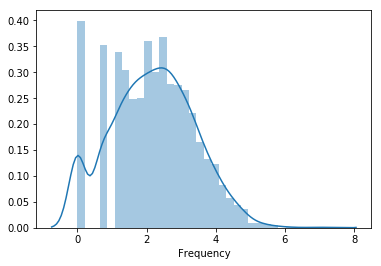

In [87]:
recency_log = np.log(datamart['Frequency'])
sns.distplot(recency_log)
plt.show()

In [88]:
def cube_root(x):
    if x >= 0:
        return x ** (1 / 3)
    else:
        return -(abs(x) ** (1 / 3))

cube_root(-27)

-3.0

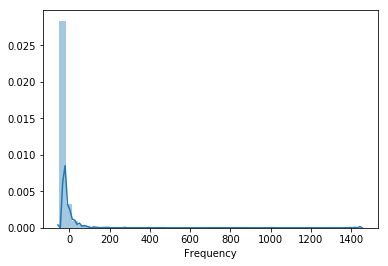

In [89]:
sns.distplot(datamart['Frequency']-50)
plt.show()

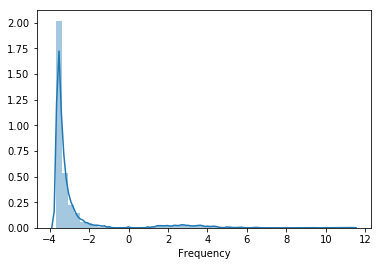

In [90]:
sns.distplot((datamart['Frequency']-50).apply(cube_root))
plt.show()

No handles with labels found to put in legend.


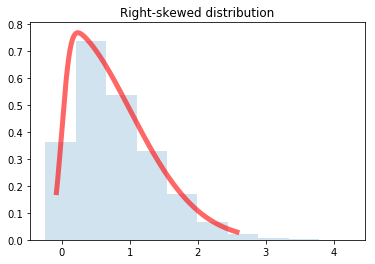

In [154]:
from scipy.stats import skewnorm
import matplotlib.pyplot as plt
import numpy as np

a = 10
# mean, var, skew, kurt = skewnorm.stats(a, moments='mvsk')

#Display the probability density function (pdf):
fig, ax = plt.subplots(1, 1)
x = np.linspace(skewnorm.ppf(0.01, a), skewnorm.ppf(0.99, a), 10000)
ax.plot(x, skewnorm.pdf(x, a),'r-', lw=5, alpha=0.6)

r = skewnorm.rvs(a, size=10000)
ax.hist(r, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.title('Right-skewed distribution')
plt.show()

No handles with labels found to put in legend.


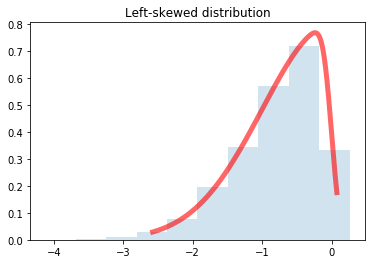

In [153]:
a = -10
#mean, var, skew, kurt = skewnorm.stats(a, moments='mvsk')

#Display the probability density function (pdf):
fig, ax = plt.subplots(1, 1)
x = np.linspace(skewnorm.ppf(0.01, a), skewnorm.ppf(0.99, a), 10000)
ax.plot(x, skewnorm.pdf(x, a),'r-', lw=5, alpha=0.6)

r = skewnorm.rvs(a, size=10000)
ax.hist(r, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.title('Left-skewed distribution')
plt.show()

No handles with labels found to put in legend.


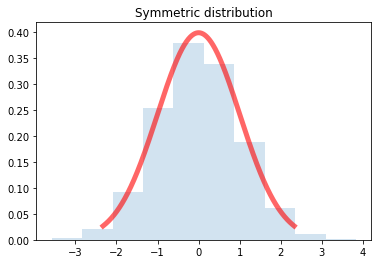

In [155]:
a = 0
#mean, var, skew, kurt = skewnorm.stats(a, moments='mvsk')

#Display the probability density function (pdf):
fig, ax = plt.subplots(1, 1)
x = np.linspace(skewnorm.ppf(0.01, a), skewnorm.ppf(0.99, a), 10000)
ax.plot(x, skewnorm.pdf(x, a),'r-', lw=5, alpha=0.6)

r = skewnorm.rvs(a, size=10000)
ax.hist(r, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.title('Symmetric distribution')
plt.show()

In [94]:
datamart_centered = datamart_rfm - datamart_rfm.mean()
datamart_centered.describe().round(2)

,Recency,Frequency,MonetaryValue
count,3643.00,3643.00,3643.00
mean,0.00,-0.00,0.00
std,94.45,43.75,1347.44
min,-89.44,-17.71,-370.04
25%,-71.44,-14.71,-311.99
50%,-39.44,-9.71,-234.32
75%,48.56,2.29,-36.34
max,274.56,1478.29,47689.66


In [95]:
datamart_scaled = datamart_rfm / datamart_rfm.std()
datamart_scaled.describe().round(2)

,Recency,Frequency,MonetaryValue
count,3643.00,3643.00,3643.00
mean,0.96,0.43,0.28
std,1.00,1.00,1.00
min,0.01,0.02,0.00
25%,0.20,0.09,0.04
50%,0.54,0.21,0.10
75%,1.47,0.48,0.25
max,3.86,34.21,35.67


In [96]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(datamart_rfm)
datamart_normalized = scaler.transform(datamart_rfm)
print('mean: ', datamart_normalized.mean(axis=0).round(2))
print('std: ', datamart_normalized.std(axis=0).round(2))

mean:  [-0. -0.  0.]
std:  [1. 1. 1.]


In [97]:
datamart_normalized.shape

(3643, 3)

### Random dataset

For 3rd exercise of lesson 3.1.

In [98]:
np.random.seed(1)
var1 = np.random.randint(100, 400, 100).round(3)
var2 = np.exp2((np.random.randn(100)) * 1.8).round(3)
var3 = np.exp2((np.random.randn(100)) * 3.1).round(3)
data = pd.DataFrame(data={'var1': var1,
                          'var2': var2,
                          'var3': var3
                          })
data.describe()

,var1,var2,var3
count,100.000000,100.00000,100.000000
mean,251.850000,1.92559,12.550280
std,90.993104,2.58373,34.516362
min,101.000000,0.04800,0.002000
25%,171.750000,0.61250,0.280750
50%,250.000000,1.17550,1.260500
75%,339.250000,2.20800,5.568000
max,397.000000,15.31200,228.779000


In [99]:
np.random.seed(1)
var1 = np.random.randint(100, 800, 100).round(3)
var2 = np.exp2((np.random.randn(100)) * 3.8).round(3)
var3 = np.exp2((np.random.randn(100)) * 6.1).round(3) + 0.001
data_1 = pd.DataFrame(data={'var1': var1,
                          'var2': var2,
                          'var3': var3
                          })
data_1.describe()

,var1,var2,var3
count,100.000000,100.000000,100.000000
mean,451.880000,13.174100,235.263860
std,192.288308,35.099872,1906.427878
min,107.000000,0.006000,0.001000
25%,305.750000,0.136250,0.068000
50%,442.000000,0.638000,0.431000
75%,609.250000,6.080750,4.039250
max,795.000000,243.805000,19002.040000


In [100]:
data_1.to_csv('dummy_data_capstone.csv')

In [101]:
data_1 = pd.read_csv('dummy_data_capstone.csv', index_col=[0])
data_1[:5]

,var1,var2,var3
0,137,0.499,992.118
1,335,9.292,0.111
2,172,243.805,0.090
3,745,4.002,425.405
4,244,13.347,0.029


In [102]:
data_1_log = np.log(data_1)
scaler = StandardScaler()
scaler.fit(data_1_log)
data_1_normalized = scaler.transform(data_1)

In [103]:
sse = {}

# Fit KMeans and calculate SSE for each `k` ranging from 1 to 20 (inclusive)
for k in range(1, 21):
  
    # initialize KMeans with `k` clusters and random state 1
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(data_1_normalized)
    
    # Assign sum of squared distances to `k` element of `sse` dictionary
    sse[k] = kmeans.inertia_ 

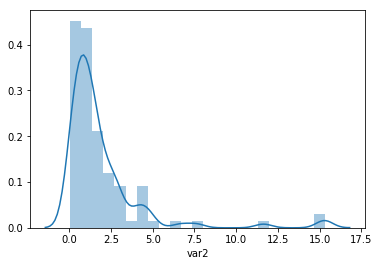

In [104]:
sns.distplot((data['var2']))

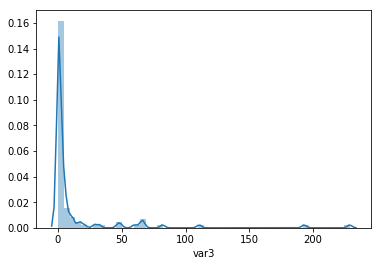

In [105]:
sns.distplot((data['var3']))

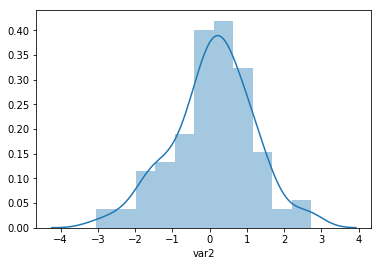

In [106]:
sns.distplot(np.log(data['var2']))

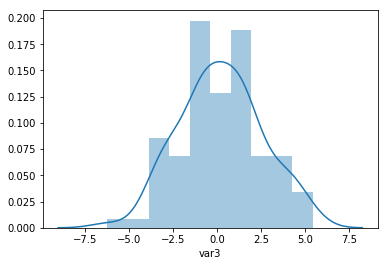

In [107]:
sns.distplot(np.log(data['var3']))

### Exercise 2 for lesson 3.2.

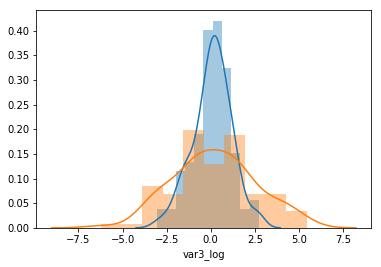

In [108]:
# apply `log` transformation to `var2`
data['var2_log'] = np.log(data['var2'])

# apply `log` transformation to `var3`
data['var3_log'] = np.log(data['var3'])

# plot distribution of `var2_log`
sns.distplot(data['var2_log'])

# plot distribution of `var3_log`
sns.distplot(data['var3_log'])

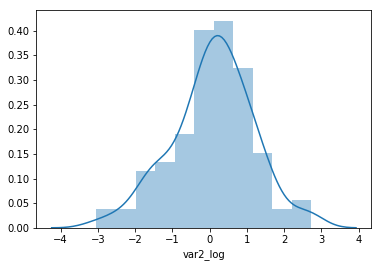

In [109]:
sns.distplot(data['var2_log'])

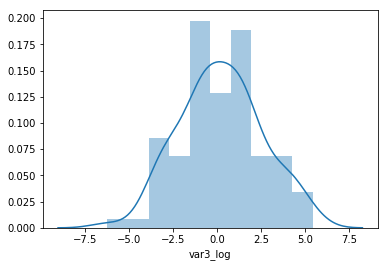

In [110]:
sns.distplot(data['var3_log'])

In [111]:
np.random.seed(1)
var1 = np.random.randint(100, 400, 100).round(3)
var2 = np.exp2((np.random.randn(100)) * 1.8).round(3)
var3 = np.exp2((np.random.randn(100)) * 3.1).round(3)
data = pd.DataFrame(data={'var1': var1,
                          'var2': var2,
                          'var3': var3
                          })
data.describe()

,var1,var2,var3
count,100.000000,100.00000,100.000000
mean,251.850000,1.92559,12.550280
std,90.993104,2.58373,34.516362
min,101.000000,0.04800,0.002000
25%,171.750000,0.61250,0.280750
50%,250.000000,1.17550,1.260500
75%,339.250000,2.20800,5.568000
max,397.000000,15.31200,228.779000


In [112]:
np.random.seed(1)
var1 = np.random.randint(100, 400, 100).round(3)
var2 = np.exp2((np.random.randn(100)) * 1.8).round(3)
var3 = np.exp2((np.random.randn(100)) * 3.1).round(3)
data = pd.DataFrame(data={'var1': var1,
                          'var2': var2,
                          'var3': var3
                          })
data.describe()

,var1,var2,var3
count,100.000000,100.00000,100.000000
mean,251.850000,1.92559,12.550280
std,90.993104,2.58373,34.516362
min,101.000000,0.04800,0.002000
25%,171.750000,0.61250,0.280750
50%,250.000000,1.17550,1.260500
75%,339.250000,2.20800,5.568000
max,397.000000,15.31200,228.779000


In [113]:
# Center the data by subtracting average values from each entry
data_centered = data - data.mean()

# Scale the data by dividing each entry by standard deviation
data_scaled = data / data.std()

# Normalize the data by applying both centering and scaling
data_normalized = (data - data.mean()) / data.std()

# Print summary statistics to make sure average is zero and standard deviation is one
data_normalized.describe().round(2)

,var1,var2,var3
count,100.00,100.00,100.00
mean,0.00,-0.00,0.00
std,1.00,1.00,1.00
min,-1.66,-0.73,-0.36
25%,-0.88,-0.51,-0.36
50%,-0.02,-0.29,-0.33
75%,0.96,0.11,-0.20
max,1.60,5.18,6.26


In [114]:
from sklearn.preprocessing import StandardScaler

# Initialize `StandardScaler` instance as `scaler`
scaler = StandardScaler()

# Fit the `scaler` to the `data`
scaler.fit(data)

# Transform the `data` by scaling and centering it with `scaler`
data_normalized = scaler.transform(data)

# Create a pandas DataFrame from 'data_normalized' by adding index and column names from `data`
data_normalized = pd.DataFrame(data_normalized, index=data.index, columns=data.columns)

# Print summary statistics to make sure average is zero and standard deviation is one
data_normalized.describe().round(2)

,var1,var2,var3
count,100.00,100.00,100.00
mean,0.00,0.00,0.00
std,1.01,1.01,1.01
min,-1.67,-0.73,-0.37
25%,-0.88,-0.51,-0.36
50%,-0.02,-0.29,-0.33
75%,0.97,0.11,-0.20
max,1.60,5.21,6.30


In [115]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

np.random.seed(1)
var1 = np.random.randint(100, 400, 100).round(3)
var2 = np.exp2((np.random.randn(100)) * 1.8).round(3)
var3 = np.exp2((np.random.randn(100)) * 3.1).round(3)
data = pd.DataFrame(data={'var1': var1,
                          'var2': var2,
                          'var3': var3
                          })

In [116]:
# Error 1 message
scaler = StandardScaler()
scaler.fit(data)
data_normalized = scaler.transform(data)

data_final = np.log(data_normalized)

C:\Users\urbonask\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


In [117]:
# Error 2 message
data_normalized = (data - data.mean()) / data.std()

data_final = np.log(data_normalized)

C:\Users\urbonask\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


In [118]:
# Error 3 message
# 1/0

### Dummy data clustering

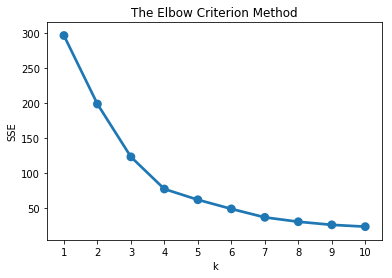

In [119]:
# https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(data_normalized)
    sse[k] = kmeans.inertia_

plt.title('The Elbow Criterion Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

### RFM data clustering

In [120]:
# Filter out 3 key metrics for the first iteration
rfm_index = ['Recency', 'Frequency', 'MonetaryValue']
datamart_rfm = datamart[rfm_index]

import numpy as np
datamart_log = np.log(datamart_rfm)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(datamart_log)
datamart_normalized = scaler.transform(datamart_log)

In [121]:
np.savetxt('datamart_rfm_normalized.csv', datamart_normalized, delimiter=',')

In [122]:
datamart_normalized = np.loadtxt('datamart_rfm_normalized.csv', delimiter=',')

In [123]:
datamart_normalized_df = pd.DataFrame(datamart_normalized, index=datamart_rfm.index, columns=datamart_rfm.columns)

In [124]:
datamart_normalized_df.to_csv('datamart_normalized_df.csv')
datamart_normalized_df = pd.read_csv('datamart_normalized_df.csv', index_col=[0])

In [125]:
print(datamart_normalized.shape, datamart_normalized_df.shape)

(3643, 3) (3643, 3)


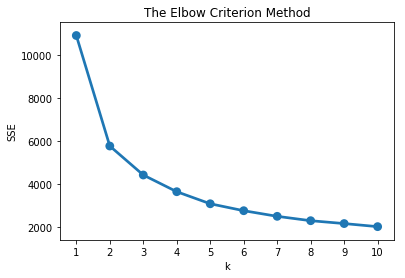

In [126]:
# https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(datamart_normalized)
    cluster_labels = kmeans.labels_
    sse[k] = kmeans.inertia_
    # Inertia = Sum of squared distances of samples to their closest cluster center.

plt.title('The Elbow Criterion Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [127]:
# Filter out 3 key metrics for the first iteration
rfm_index = ['Recency', 'Frequency', 'MonetaryValue']
datamart_rfm = datamart[rfm_index]

kmeans = KMeans(n_clusters=2, random_state=1)
kmeans.fit(datamart_normalized)
cluster_labels = kmeans.labels_

datamart_rfm_k2 = datamart_rfm.assign(Cluster = cluster_labels)
datamart_rfm_k2.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count'],
}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         137.0       5.0          92.0  2023
1          32.0      35.0         719.0  1620

In [128]:
# Filter out 3 key metrics for the first iteration
rfm_index = ['Recency', 'Frequency', 'MonetaryValue']
datamart_rfm = datamart[rfm_index]

kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(datamart_normalized)
cluster_labels = kmeans.labels_

datamart_rfm_k3 = datamart_rfm.assign(Cluster = cluster_labels)
datamart_rfm_k3.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count'],
}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          16.0      50.0        1051.0   901
1         167.0       3.0          53.0  1156
2          77.0      12.0         216.0  1586

## Relative importance of cluster attributes

In [129]:
# https://inseaddataanalytics.github.io/INSEADAnalytics/CourseSessions/Sessions45/ClusterAnalysisReading.html 
# kmeans_rfm_k3 = datamart_rfm_k3.groupby(['cluster']).agg({
#     'Recency': 'mean',
#     'Frequency': 'mean',
#     'MonetaryValue': ['mean', 'count'],
# })

cluster_avg = datamart_rfm_k3.groupby(['Cluster']).mean() 
population_avg = datamart_rfm.mean()
relative_imp = cluster_avg / population_avg - 1
relative_imp.round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,-0.82,1.68,1.83
1,0.84,-0.84,-0.86
2,-0.15,-0.34,-0.42


In [130]:
print(relative_imp.round(2))

         Recency  Frequency  MonetaryValue
Cluster                                   
0          -0.82       1.68           1.83
1           0.84      -0.84          -0.86
2          -0.15      -0.34          -0.42


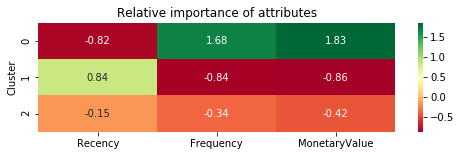

In [131]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 2))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

### Snake plot of standardized attributes

In [132]:
# https://seaborn.pydata.org/generated/seaborn.lineplot.html
# SNAKE PLOTS ir MARKET RESEARCH - http://www.marketingprofs.com/tutorials/snakeplot.asp

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(datamart_rfm)
datamart_normalized = scaler.transform(datamart_rfm)
datamart_normalized = pd.DataFrame(datamart_normalized, 
                                   index=datamart_rfm.index, 
                                   columns=datamart_rfm.columns)
datamart_normalized['Cluster'] = datamart_rfm_k3['Cluster']

In [133]:
datamart_melt = pd.melt(datamart_normalized.reset_index(), 
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'MonetaryValue'], 
                        var_name='Metric', 
                        value_name='Value')

In [134]:
datamart_melt.to_csv('datamart_rfm_melted_k3.csv')
datamart_melt = pd.read_csv('datamart_rfm_melted_k3.csv', index_col=[0])

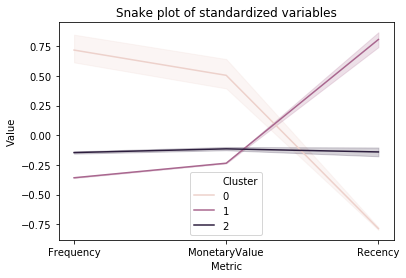

In [135]:
import seaborn as sns #; sns.set()
import matplotlib.pyplot as plt
plt.title('Snake plot of standardized variables')
sns.lineplot(x="Metric", y="Value", hue='Cluster', data=datamart_melt)

### Kmeans on raw data

In [136]:
# # Filter out 3 key metrics for the first iteration
# rfm_index = ['Recency', 'Frequency', 'MonetaryValue']
# datamart_rfm = datamart[rfm_index]

# kmeans = KMeans(n_clusters=3, random_state=1)
# kmeans.fit(datamart_rfm)
# cluster_labels = kmeans.labels_

# datamart_rfm = datamart_rfm.assign(cluster = cluster_labels)
# datamart_rfm.groupby(['cluster']).agg({
#     'Recency': 'mean',
#     'Frequency': 'mean',
#     'MonetaryValue': ['mean', 'count'],
# }).round(0)

### RFM+T data clustering

In [137]:
datamart_rfmt = datamart[['Recency', 'Frequency', 'MonetaryValue', 'Tenure']]
datamart_rfmt.to_csv('datamart_rfmt.csv')
datamart_rfmt = pd.read_csv('datamart_rfmt.csv', index_col=[0])
datamart_rfmt[:5]

,Recency,Frequency,MonetaryValue,Tenure
CustomerID,,,,
12747,3,25,948.70,362
12748,1,888,7046.16,365
12749,4,37,813.45,214
12820,4,17,268.02,327
12822,71,9,146.15,88


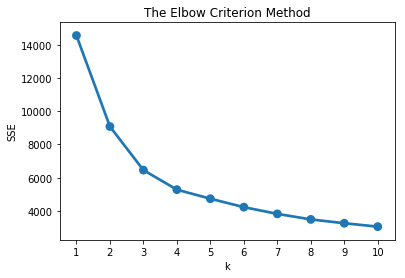

In [138]:
import numpy as np
datamart_rfmt_log = np.log(datamart_rfmt)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(datamart_rfmt_log)
datamart_rfmt_normalized = scaler.transform(datamart_rfmt_log)

# https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(datamart_rfmt_normalized)
    cluster_labels = kmeans.labels_
    sse[k] = kmeans.inertia_
    # Inertia = Sum of squared distances of samples to their closest cluster center.

plt.title('The Elbow Criterion Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [139]:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(datamart_rfmt_normalized)
cluster_labels = kmeans.labels_

datamart_rfmt = datamart_rfmt.assign(cluster = cluster_labels)
datamart_rfmt.groupby(['cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean',
    'Tenure': ['mean', 'count'],
}).round(0)


Recency Frequency MonetaryValue Tenure      
           mean      mean          mean   mean count
cluster                                             
0          33.0      38.0         788.0  271.0  1426
1         184.0       6.0         104.0  237.0  1364
2          37.0       7.0         101.0   50.0   853

In [140]:
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(datamart_rfmt_normalized)
cluster_labels = kmeans.labels_

datamart_rfmt = datamart_rfmt.assign(cluster = cluster_labels)
datamart_rfmt.groupby(['cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean',
    'Tenure': ['mean', 'count'],
}).round(0)


Recency Frequency MonetaryValue Tenure      
           mean      mean          mean   mean count
cluster                                             
0          13.0      54.0        1142.0  280.0   776
1         203.0       3.0          58.0  222.0   919
2          90.0      15.0         278.0  248.0  1203
3          33.0       7.0         102.0   45.0   745

In [141]:
np.savetxt('cluster_labels_k4_rfmt.csv', cluster_labels.astype(int), fmt='%i', delimiter=',')

In [142]:
cluster_labels_k4 = np.loadtxt('cluster_labels_k4_rfmt.csv', delimiter=',')
cluster_labels_k4 = cluster_labels_k4.astype(int)

In [143]:
cluster_labels_k4[:10]

array([0, 0, 0, 0, 2, 1, 3, 0, 3, 0])

In [144]:
cluster_labels[:10]

array([0, 0, 0, 0, 2, 1, 3, 0, 3, 0])

In [145]:
datamart_rfm[:5]

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,3,25,948.70
12748,1,888,7046.16
12749,4,37,813.45
12820,4,17,268.02
12822,71,9,146.15


In [146]:
np.log(datamart_rfm)[:5]

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,1.098612,3.218876,6.855093
12748,0.000000,6.788972,8.860238
12749,1.386294,3.610918,6.701284
12820,1.386294,2.833213,5.591062
12822,4.262680,2.197225,4.984633


In [147]:
# Apply log transformation to unskew the data and store as `datamart_log`
datamart_log = np.log(datamart_rfm)

# Initialize `StandardScaler` instance as `scaler`
scaler = StandardScaler()

# Fit the `scaler` to the `datamart_log`
scaler.fit(datamart_log)

# Transform the `data` by scaling and centering it with `scaler`
data_normalized = scaler.transform(datamart_log)

# Create a pandas DataFrame from 'data_normalized' by adding index and column names from `datamart_rfm`
data_normalized = pd.DataFrame(data_normalized, index=datamart_rfm.index, columns=datamart_rfm.columns)

In [148]:
data_normalized.to_csv('datamart_rfm_normalized.csv')

In [149]:
data_normalized = pd.read_csv('datamart_rfm_normalized.csv', index_col=[0])

In [150]:
data_normalized[:5]

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,-2.002202,0.865157,1.464940
12748,-2.814518,3.815272,2.994692
12749,-1.789490,1.189117,1.347598
12820,-1.789490,0.546468,0.500595
12822,0.337315,0.020925,0.037943


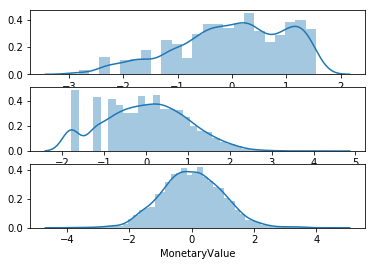

In [152]:
plt.subplot(3,1,1); sns.distplot(data_normalized['Recency'])
plt.subplot(3,1,2); sns.distplot(data_normalized['Frequency'])
plt.subplot(3,1,3); sns.distplot(data_normalized['MonetaryValue'])
plt.show()